# Python Project: Harits Muhammad (GoFinance)

Link: https://docs.google.com/document/d/11j3ep-6_PaNIrPJIETtQT7JwAf6EROHNpn8b9EtP6F4/edit?pli=1

1. The project should solve a Gojek problem
2. To pass, the project has to contain:
    - Querying directly from Jupyterlab/ Jupyter Notebook (you are prohibited to query directly from BQ site, and then download CSV, and then manually read it into your Jupyter Notebook/lab) because we want a reproducible output with minimum friction
    - Use our Python’s main visualization package tools: matplotlib and seaborn
    - Data manipulation
        - Create new columns
        - Filtering rows
        - Group by aggregations
        - Sorting
        - Dataframe melt() and pivot() 
        - Create neat functions that do data manipulation (if you utilize the cheat sheet that is provided, this will be easy to achieve)
3. The project should be done in iPython Notebook format (.ipynb)

# GoFinance Fraud Analysis

### Background Overview
Previously, Gojek Fraud joined with GoFinance Risk created [fraud inputs for PayLater whitelist](https://docs.google.com/document/d/1CUVdierFTeKKHWEdeBYvR5BI5sAdXhaQMI9lQh-xM2o/edit#) & [PayLater fraud rules in general (for preventive and heuristic)](https://docs.google.com/document/d/1VCgohM9aoYtdBdSgsEqMFumy5BgrcmovKYxM2ZBENKI/edit#) back around Q1 2019. In this present time, GoFinance BI and Risk team need to recheck those fraud preventive threshold with layering on the current A-Score bins (Kimba) in order to decide whether we need to update the threshold or stick to the current threshold.

There are 8 parameters inputs prior customers get eligible for PayLater usage.

1. Tiers of severity with Customer / Driver Suspension History
2. Number of devices linked to that customer/driver account
3. Number of invalid device IDs (indicates device is tampered with)
4. Number of phone number changes
5. Time between account creation and first booking
6. OTP Attempt
7. Customer Uniqueness
8. Driver Uniqueness

### Purpose
The purpose of the analysis is to reduce loan default rate on GoFinance consumer product by screening customers with fraud data inputs. This document lists out Fraud data inputs and their recommended thresholds.

In this Jupyter Notebook, I only focus on __"Time between account creation and first booking"__

### Methodology
1. Population (In the last 3 months)
    - Customers without PayLater who transact post 1 hour, 24 hours, 1 month, 2 months, 3 months, after sign up to gojek
    - Customers with PayLater who transact post 1 hour, 24 hours, 1 month, 2 months, 3 months, after activating PayLater from the above population
2. What data to get: 
    - The gojek service type they purchase
    - Average transactions they do to max out the limit

### Step 1: Libraries Setup & Get Raw Data

In [2]:
from pandas.io import gbq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date, datetime, timedelta
from datetime_truncate import truncate

In [120]:
#BQ credentials
bq_id = 'bi-gojek'
bq_dialect = 'standard'
def get_data(bq_id,bq_dialect,query):
    data = gbq.read_gbq(query=query, project_id=bq_id, dialect = bq_dialect)
    return data

query = """
select 
    a.* 
--     except( # EXCLUDE COUPLE OF COLUMNS FOR PYTHON PROJECT PURPOSES
--     minute_created_to_gopay,
--     hour_created_to_gopay,
--     day_created_to_gopay,
--     minute_activate_to_adopt_pl,
--     hour_activate_to_adopt_pl,
--     day_activate_to_adopt_pl,
--     condition_created_to_gopay,
--     condition_activate_to_adopt_pl
--     )
    ,
    if (b.customer_id is not null, 1, 0) as is_blacklisted,
    DATE_BLACKLISTED
from 
  `bi-gojek.log_gofinance.xx_harits_fraud_pl_analysis_20200306` a
left join
  `log_gofinance.xx_bq_customer_blacklist_20200313` b
on
  a.customer_id = cast(b.customer_id as int64)
where
  a.date_customer_created_at
  between '2019-01-01' and '2020-02-29'
"""

original_df = get_data(bq_id,bq_dialect,query)

### Step 2: Get to know our data

We want to know what kind of raw dataset that we're dealing with. So I use .info() and .head()

In [121]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11022150 entries, 0 to 11022149
Data columns (total 26 columns):
customer_id                                          int64
date_customer_created_at                             datetime64[ns]
datetime_customer_created_at                         datetime64[ns]
date_first_booking_complete_date_gopay_or_p2p        datetime64[ns]
datetime_first_booking_complete_date_gopay_or_p2p    datetime64[ns]
paylater_adoption_date                               datetime64[ns]
very_first_service_gopay                             object
due_date                                             datetime64[ns]
pl_spend                                             float64
outstanding_principal                                float64
dpd                                                  float64
paylater_activate_date                               datetime64[ns]
paylater_activate_datetime                           datetime64[ns]
paylater_adoption_datetime             

In [122]:
original_df.head()

,customer_id,date_customer_created_at,datetime_customer_created_at,date_first_booking_complete_date_gopay_or_p2p,datetime_first_booking_complete_date_gopay_or_p2p,paylater_adoption_date,very_first_service_gopay,due_date,pl_spend,outstanding_principal,...,minute_created_to_gopay,hour_created_to_gopay,day_created_to_gopay,minute_activate_to_adopt_pl,hour_activate_to_adopt_pl,day_activate_to_adopt_pl,condition_created_to_gopay,condition_activate_to_adopt_pl,is_blacklisted,DATE_BLACKLISTED
0,634315405,2019-05-26,2019-05-26 22:26:54.766783,2019-05-26,2019-05-26 22:27:59.095000,NaT,GO-PULSA,NaT,NaN,NaN,...,1,0,0,NaN,NaN,NaN,1. < 1 H,None,0,NaT
1,624595379,2019-03-01,2019-03-01 14:44:41.094093,2019-03-01,2019-03-01 14:50:44.000000,NaT,GO-DEALS,NaT,NaN,NaN,...,6,0,0,NaN,NaN,NaN,1. < 1 H,None,0,NaT
2,632003962,2019-05-07,2019-05-07 23:34:13.059694,2019-05-09,2019-05-09 21:39:45.339000,NaT,P2P - RECEIVE,NaT,NaN,NaN,...,2765,46,2,NaN,NaN,NaN,3. 1 - 30 Days,None,0,NaT
3,618606285,2019-01-09,2019-01-09 06:15:18.075752,2019-05-07,2019-05-07 12:45:29.858747,NaT,GO-FOOD,NaT,NaN,0.0,...,170310,2838,118,NaN,NaN,NaN,6. > 90 Days,None,0,NaT
4,621853380,2019-02-09,2019-02-09 11:32:43.916198,2019-06-02,2019-06-02 23:11:03.138000,NaT,GO-RIDE,NaT,NaN,NaN,...,163419,2724,113,NaN,NaN,NaN,6. > 90 Days,None,0,NaT


The informations above show that we're dealing with a couple of crucial datapoints at customer_id level where describes each pinpoint about when do customers created their Gojek account, when they transacted with Gopay for the very first time and what's the service type, when do customers activated PayLater, until the first time they adopt PayLater and on which service type. No need to change the datatype on a certain column for now.

I think it might be good to add a couple of additional columns:
- Difference between Gojek created account to first Gopay transaction in day, hour, minute.
- Difference between Activate PayLater to Adopt PayLater in day, hour, minute.
- A condition that describe above statements:
    1. < 1 H
    2. 1 - 24 H
    3. 1 - 30 Days
    4. 31 - 60 Days
    5. 61 - 90 Days
    6. '>' 90 Days

### Step 3: Data Manipulation



Add new columns.

In [6]:
# Add datetrunc columns
original_df['datetrunc_customer_created_at'] = original_df['datetime_customer_created_at'].map(lambda x: 100* x.year + x.month)
original_df['datetrunc_first_booking_complete_date_gopay_or_p2p'] = original_df['datetime_first_booking_complete_date_gopay_or_p2p'].map(lambda x: 100* x.year + x.month)
original_df['paylater_adoption_datetrunc'] = original_df['paylater_adoption_datetime'].map(lambda x: 100* x.year + x.month)
original_df['paylater_activate_datetrunc'] = original_df['paylater_activate_datetime'].map(lambda x: 100* x.year + x.month)

# Add date diff columns
diff_created_to_gopay = (original_df['datetime_first_booking_complete_date_gopay_or_p2p'] - original_df['datetime_customer_created_at'])
original_df['minute_created_to_gopay'] = diff_created_to_gopay  / np.timedelta64(1, 'm')
original_df['hour_created_to_gopay'] = diff_created_to_gopay  / np.timedelta64(1, 'h')
original_df['day_created_to_gopay'] = diff_created_to_gopay / np.timedelta64(1, 'D')

diff_activate_to_adopt_pl = (original_df['paylater_adoption_datetime'] - original_df['paylater_activate_datetime'])
original_df['minute_activate_to_adopt_pl'] = diff_activate_to_adopt_pl  / np.timedelta64(1, 'm')
original_df['hour_activate_to_adopt_pl'] = diff_activate_to_adopt_pl  / np.timedelta64(1, 'h')
original_df['day_activate_to_adopt_pl'] = diff_activate_to_adopt_pl  / np.timedelta64(1, 'D')

# Add condition from date diff results
def condition_date_diff(df):
    if(df['minute'] < 61):
        st = '1. < 1 H'
    elif((df['hour'] >= 1) & (df['hour'] < 25)):
        st = '2. 1 - 24 H'
    elif((df['day'] >= 1) & (df['day'] <31)):
        st = '3. 1 - 30 Days'
    elif((df['day'] >= 31) & (df['day'] <61)):
        st = '4. 31 - 60 Days'
    elif((df['day'] >= 61) & (df['day'] <91)):
        st = '5. 61 - 90 Days'
    elif(df['day'] >= 91 ):
        st = '6. > 90 Days'
    else:
        st = None
    return st
    
created_to_gopay = pd.DataFrame()
created_to_gopay['minute'] = original_df['minute_created_to_gopay']
created_to_gopay['hour'] = original_df['hour_created_to_gopay']
created_to_gopay['day'] = original_df['day_created_to_gopay']

activate_to_adopt_pl = pd.DataFrame()
activate_to_adopt_pl['minute'] = original_df['minute_activate_to_adopt_pl']
activate_to_adopt_pl['hour'] = original_df['hour_activate_to_adopt_pl']
activate_to_adopt_pl['day'] = original_df['day_activate_to_adopt_pl']
    
original_df['condition_created_to_gopay'] = created_to_gopay.apply(condition_date_diff, axis = 1) 
original_df['condition_activate_to_adopt_pl'] = activate_to_adopt_pl.apply(condition_date_diff, axis = 1) 
    

Check the difference with .info()

In [7]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7759641 entries, 0 to 7759640
Data columns (total 28 columns):
customer_id                                           int64
date_customer_created_at                              datetime64[ns]
datetime_customer_created_at                          datetime64[ns]
date_first_booking_complete_date_gopay_or_p2p         datetime64[ns]
datetime_first_booking_complete_date_gopay_or_p2p     datetime64[ns]
paylater_adoption_date                                datetime64[ns]
very_first_service_gopay                              object
due_date                                              datetime64[ns]
pl_spend                                              float64
outstanding_principal                                 float64
dpd                                                   float64
paylater_activate_date                                datetime64[ns]
paylater_activate_datetime                            datetime64[ns]
paylater_adoption_datetime  

In [8]:
original_df.head()

,customer_id,date_customer_created_at,datetime_customer_created_at,date_first_booking_complete_date_gopay_or_p2p,datetime_first_booking_complete_date_gopay_or_p2p,paylater_adoption_date,very_first_service_gopay,due_date,pl_spend,outstanding_principal,...,paylater_adoption_datetrunc,paylater_activate_datetrunc,minute_created_to_gopay,hour_created_to_gopay,day_created_to_gopay,minute_activate_to_adopt_pl,hour_activate_to_adopt_pl,day_activate_to_adopt_pl,condition_created_to_gopay,condition_activate_to_adopt_pl
0,638095935,2019-06-28,2019-06-28 15:29:14.275657,2019-07-01,2019-07-01 06:52:05.431000,NaT,GO-PULSA,NaT,NaN,NaN,...,NaN,NaN,3802.852589,63.380876,2.640870,NaN,NaN,NaN,3. 1 - 30 Days,None
1,642330975,2019-07-23,2019-07-23 19:09:27.905319,2019-07-29,2019-07-29 11:22:26.996774,NaT,GO-FOOD,NaT,NaN,NaN,...,NaN,NaN,8172.984858,136.216414,5.675684,NaN,NaN,NaN,3. 1 - 30 Days,None
2,644099282,2019-07-31,2019-07-31 22:25:23.519191,2019-09-02,2019-09-02 09:23:21.646000,NaT,GO-RIDE,NaT,NaN,NaN,...,NaN,NaN,46737.968780,778.966146,32.456923,NaN,NaN,NaN,4. 31 - 60 Days,None
3,644401732,2019-08-03,2019-08-03 01:12:11.709475,2019-08-08,2019-08-08 13:25:52.476000,NaT,GO-CAR,NaT,NaN,NaN,...,NaN,NaN,7933.679442,132.227991,5.509500,NaN,NaN,NaN,3. 1 - 30 Days,None
4,647463196,2019-08-24,2019-08-24 16:08:54.669740,2019-09-06,2019-09-06 17:37:34.791000,NaT,GO-CAR,NaT,NaN,NaN,...,NaN,NaN,18808.668688,313.477811,13.061575,NaN,NaN,NaN,3. 1 - 30 Days,None


There are a couple of newly added columns in the dataframe. That's should be it! Now continue to analyse the data.

### Step 4: Analysis and Result

#### _Part 1: Gojek account creation to First Gopay Transaction_

Before we continue, for first analysis between account created and first Gopay transaction, we also want to limit the datas into last three months only based on Gojek account creation (December 2019 to February 2020) just to limit population purpose.

[Tutorial here](https://stackoverflow.com/questions/151199/how-to-calculate-number-of-days-between-two-given-dates)

In [123]:
df_1 = original_df[(original_df['date_customer_created_at'] >= '2019-12-01') & (original_df['date_customer_created_at'] < '2020-03-01')]

First thing first, I want to know what's the highest count of Gojek service using Gopay after they signed up.

[Tutorial link](https://stackoverflow.com/questions/37148787/pandas-pivot-table-percent-calculations)

In [124]:
table_1 = pd.pivot_table(df_1[['very_first_service_gopay','customer_id']], 
                            index = ['very_first_service_gopay'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_1 = table_1.sort_values(by=['customer_id'], ascending=False)
table_1['% of Total'] = (table_1.customer_id / table_1.customer_id.sum())
table_1

,customer_id,% of Total
very_first_service_gopay,,
GO-FOOD,508736,0.320703
P2P - RECEIVE,478167,0.301433
GO-RIDE,400570,0.252516
GO-CAR,151952,0.095789
GO-PULSA,18194,0.011469
P2P - SEND,12804,0.008072
GO-CAR-XTRA,7284,0.004592
GO-BILLS,4818,0.003037
GO-SEND,2340,0.001475


Interestingly, __P2P - RECEIVE is the second for the very first Gopay transaction (31.09%) after customers created a Gojek account__. This should be aligned with analysis from Gopay fraud team in the first place that fraudulent or money laundring activities mostly come from P2P transfers. But not sure if it's only specific to RECEIVE only.

Next, I want to know the day difference from account created to first Gopay transaction distribution from each service type.

In [11]:
df_1.groupby('very_first_service_gopay')['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
very_first_service_gopay,,,,,,,,
GO-FOOD,508736.0,3.037326,7.446347,0.001316,0.130732,0.763267,2.456410,98.636681
P2P - RECEIVE,478167.0,6.703626,13.445576,0.000199,0.302319,1.470535,5.410330,98.427439
GO-RIDE,400570.0,20.283490,14.707228,0.004338,11.136170,16.371596,26.414772,97.661923
GO-CAR,151952.0,21.740821,16.740998,0.005618,10.797245,17.004883,29.210503,98.622018
GO-PULSA,18194.0,20.412890,21.144434,0.001416,3.949375,12.732731,30.702450,96.932636
P2P - SEND,12804.0,14.068738,18.004881,0.005009,1.576379,6.963358,18.824040,98.004708
GO-CAR-XTRA,7284.0,24.643046,12.390790,0.015519,14.604786,23.520367,31.653610,92.940316
GO-BILLS,4818.0,17.271126,18.772997,0.001314,2.868162,9.980599,26.733146,96.537629
GO-SEND,2340.0,13.233909,17.091966,0.007091,1.166503,5.252781,18.884875,97.155050


Text(0.5, 1.0, 'Day Diff. by Service Type (Count Customer > 2000)')

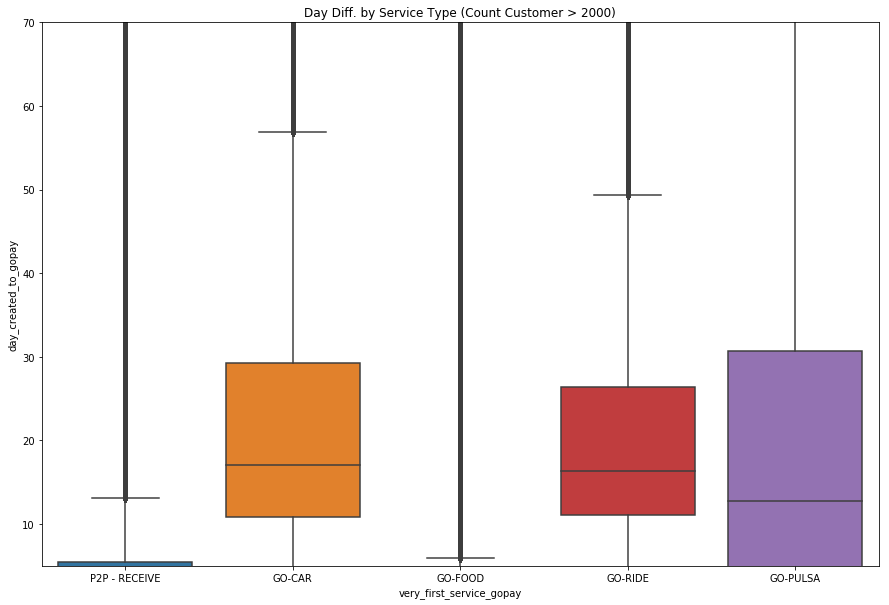

In [12]:
df_1a = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-RIDE', 'GO-PULSA', 'GO-CAR','GO-FOOD','P2P - RECEIVE']))]

f = plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='very_first_service_gopay', y='day_created_to_gopay', data=df_1a)
ax.set(ylim=(5, 70))

plt.title("Day Diff. by Service Type (Count Customer > 2000)")

- Some crucial service types (mainly Gojek core service type) have percentile 25% below around 10 days on days between acc. Created to first Gopay transaction
- While GO-FOOD and P2P have percentile 25% are still within the same day. Should look at the hours distribution.


In [13]:
df_1.groupby('very_first_service_gopay')['hour_created_to_gopay'].describe().sort_values(by=['count'], ascending=False).to_clipboard

<bound method NDFrame.to_clipboard of                              count        mean         std        min  \
very_first_service_gopay                                                
GO-FOOD                   508736.0   72.895828  178.712340   0.031578   
P2P - RECEIVE             478167.0  160.887021  322.693829   0.004767   
GO-RIDE                   400570.0  486.803768  352.973466   0.104121   
GO-CAR                    151952.0  521.779693  401.783945   0.134838   
GO-PULSA                   18194.0  489.909364  507.466413   0.033984   
P2P - SEND                 12804.0  337.649715  432.117143   0.120226   
GO-CAR-XTRA                 7284.0  591.433107  297.378951   0.372454   
GO-BILLS                    4818.0  414.507024  450.551925   0.031544   
GO-SEND                     2340.0  317.613806  410.207194   0.170187   
GO-TIX                       625.0  156.339575  379.348223   0.018936   
GO-SHOP                      415.0  401.163908  473.923900   0.160673   
GO-MASSAGE   

Text(0.5, 1.0, 'Hour Diff. by Service Type (GO-FOOD and P2P)')

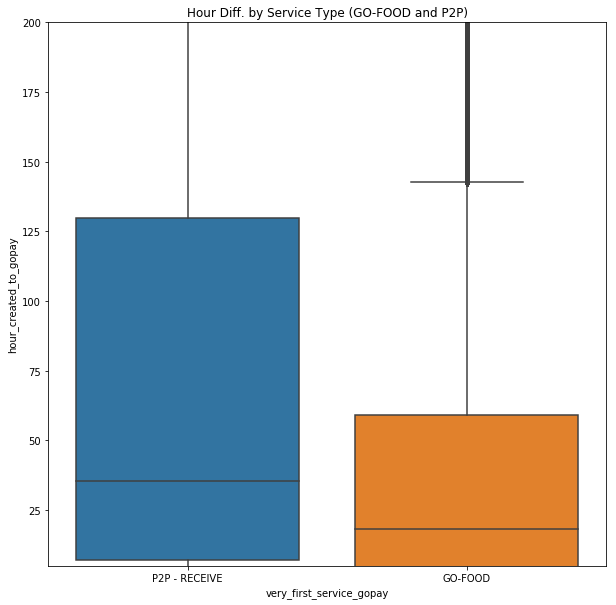

In [14]:
df_1b = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-FOOD', 'P2P - RECEIVE']))]

f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='very_first_service_gopay', y='hour_created_to_gopay', data=df_1b)
ax.set(ylim=(5, 200))

plt.title("Hour Diff. by Service Type (GO-FOOD and P2P)")

- If we dig deeper into hour level, interestingly GO-FOOD and P2P - RECEIVE are being first transact using Gopay within 12 hours only at 25% percentile.

Text(0.5, 1.0, 'Days between Acc. Created to First Gopay Transaction (GO-FOOD)')

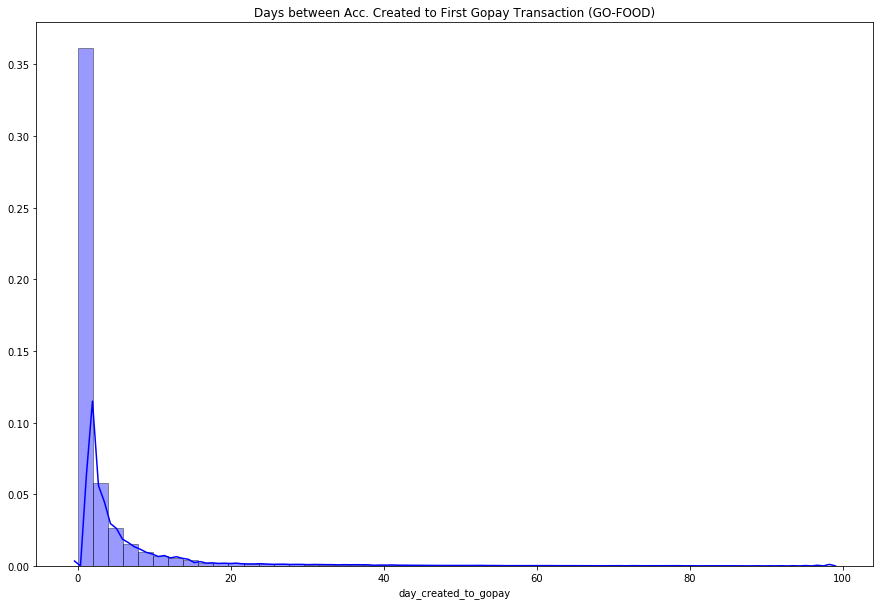

In [15]:
f = plt.figure(figsize=(15, 10))

df_1c = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-FOOD']))]

sns.distplot(df_1c['day_created_to_gopay'], hist = True, kde = True,
            color = 'blue',
            hist_kws={'edgecolor':'black'})

plt.title("Days between Acc. Created to First Gopay Transaction (GO-FOOD)")

Text(0.5, 1.0, 'Days between Acc. Created to First Gopay Transaction (P2P)')

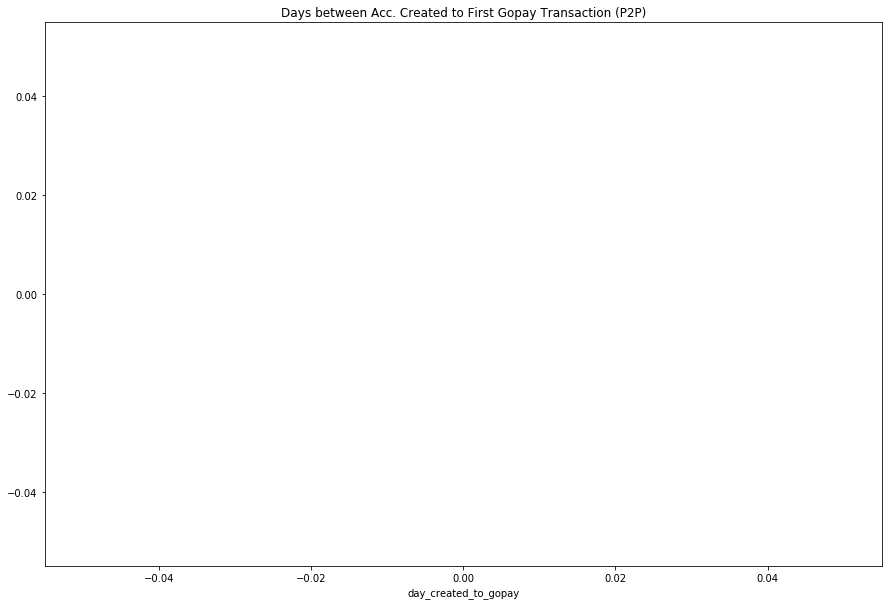

In [17]:
f = plt.figure(figsize=(15, 10))

df_4b = df_1.loc[(df_1.very_first_service_gopay.isin(['P2P']))]

sns.distplot(df_4b['day_created_to_gopay'], hist = True, kde = True,
            color = 'blue',
            hist_kws={'edgecolor':'black'})

plt.title("Days between Acc. Created to First Gopay Transaction (P2P)")

Text(0.5, 1.0, 'Days between Acc. Created to First Gopay Transaction (GO-RIDE)')

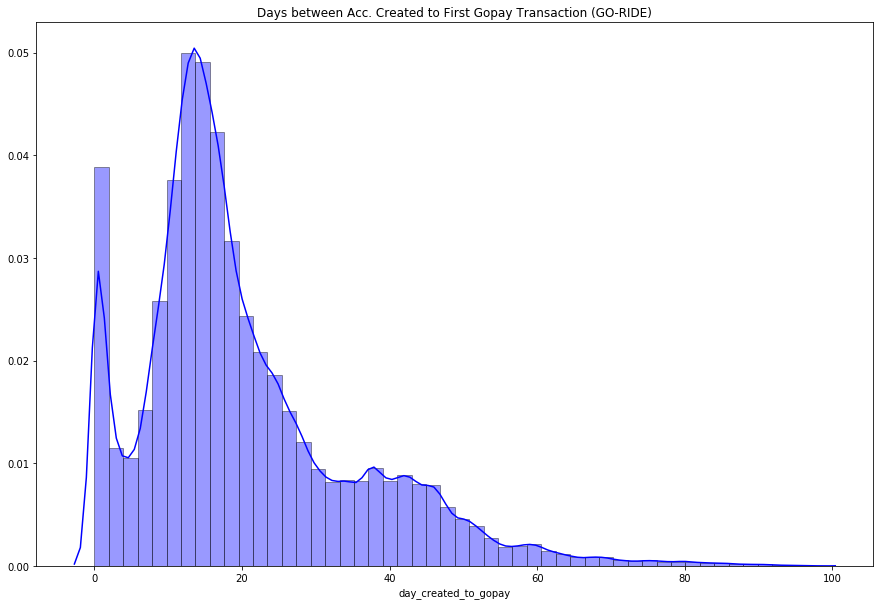

In [18]:
f = plt.figure(figsize=(15, 10))

df_4c = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-RIDE']))]

sns.distplot(df_4c['day_created_to_gopay'], hist = True, kde = True,
            color = 'blue',
            hist_kws={'edgecolor':'black'})

plt.title("Days between Acc. Created to First Gopay Transaction (GO-RIDE)")

Text(0.5, 1.0, 'Days between Acc. Created to First Gopay Transaction (GO-PULSA)')

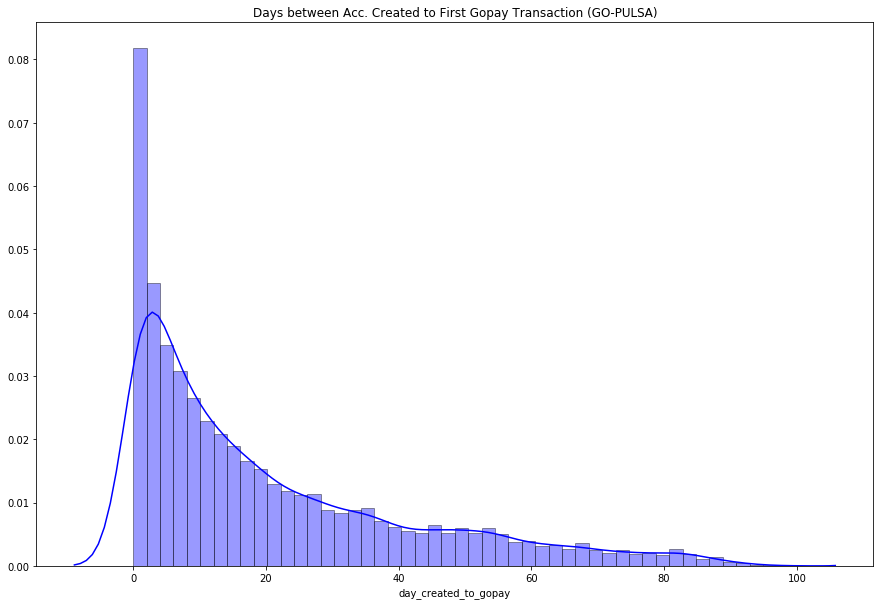

In [19]:
f = plt.figure(figsize=(15, 10))

df_4d = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-PULSA']))]

sns.distplot(df_4d['day_created_to_gopay'], hist = True, kde = True,
            color = 'blue',
            hist_kws={'edgecolor':'black'})

plt.title("Days between Acc. Created to First Gopay Transaction (GO-PULSA)")

Text(0.5, 1.0, 'Days between Acc. Created to First Gopay Transaction (GO-CAR)')

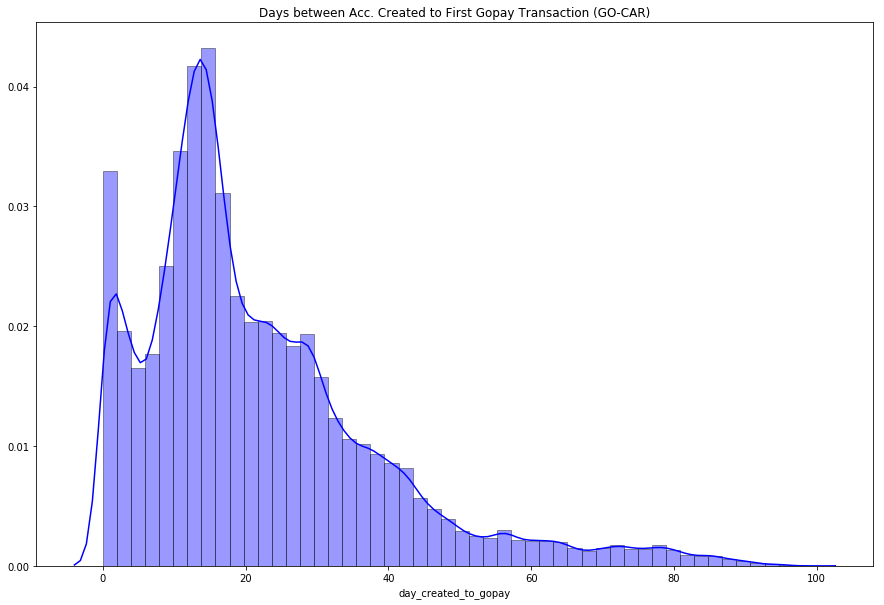

In [20]:
f = plt.figure(figsize=(15, 10))

df_4d = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-CAR']))]

sns.distplot(df_4d['day_created_to_gopay'], hist = True, kde = True,
            color = 'blue',
            hist_kws={'edgecolor':'black'})

plt.title("Days between Acc. Created to First Gopay Transaction (GO-CAR)")

In [21]:
table_2 = pd.pivot_table(df_1[['very_first_service_gopay','condition_created_to_gopay', 'customer_id']], 
                            index = ['condition_created_to_gopay','very_first_service_gopay'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)
table_2a = table_2.unstack(level=0).fillna(0)
table_2a

customer_id                             \
condition_created_to_gopay    1. < 1 H 2. 1 - 24 H 3. 1 - 30 Days   
very_first_service_gopay                                            
GO-BILLS                         233.0       486.0         3142.0   
GO-BLUEBIRD                        3.0        17.0           14.0   
GO-BOX                             1.0         0.0            2.0   
GO-CAR                          1266.0      5154.0       112083.0   
GO-CAR-XTRA                        3.0        39.0         5325.0   
GO-CLEAN                           0.0        17.0           17.0   
GO-FOOD                        85387.0    212116.0       202643.0   
GO-GLAM                            0.0         1.0            1.0   
GO-MART                            2.0         4.0           27.0   
GO-MASSAGE                        72.0        57.0           49.0   
GO-PULSA                         509.0      1556.0        11641.0   
GO-RIDE                         6120.0     18116.0       297884.0   
GO-SEND                          175.0       379.0         1381.0   
GO-SEND-SAMEDAY                    0.0        27.0           50.0   
GO-SHOP                           23.0        66.0          245.0   
GO-TIX                           305.0       113.0          158.0   
P2P - RECEIVE                  58145.0    151066.0       238479.0   
P2P - SEND                       563.0      2139.0         8233.0   

                                                                         
condition_created_to_gopay 4. 31 - 60 Days 5. 61 - 90 Days 6. > 90 Days  
very_first_service_gopay                                                 
GO-BILLS                             758.0           194.0          5.0  
GO-BLUEBIRD                            3.0             2.0          0.0  
GO-BOX                                 3.0             0.0          0.0  
GO-CAR                             27445.0          5883.0        121.0  
GO-CAR-XTRA                         1826.0            90.0          1.0  
GO-CLEAN                               2.0             0.0          0.0  
GO-FOOD                             6922.0          1594.0         74.0  
GO-GLAM                                0.0             0.0          0.0  
GO-MART                                6.0             2.0          0.0  
GO-MASSAGE                             9.0             4.0          0.0  
GO-PULSA                            3264.0          1201.0         23.0  
GO-RIDE                            71732.0          6571.0        147.0  
GO-SEND                              349.0            55.0          1.0  
GO-SEND-SAMEDAY                       11.0             5.0          0.0  
GO-SHOP                               59.0            22.0          0.0  
GO-TIX                                33.0            16.0          0.0  
P2P - RECEIVE                      22992.0          7275.0        210.0  
P2P - SEND                          1372.0           488.0          9.0

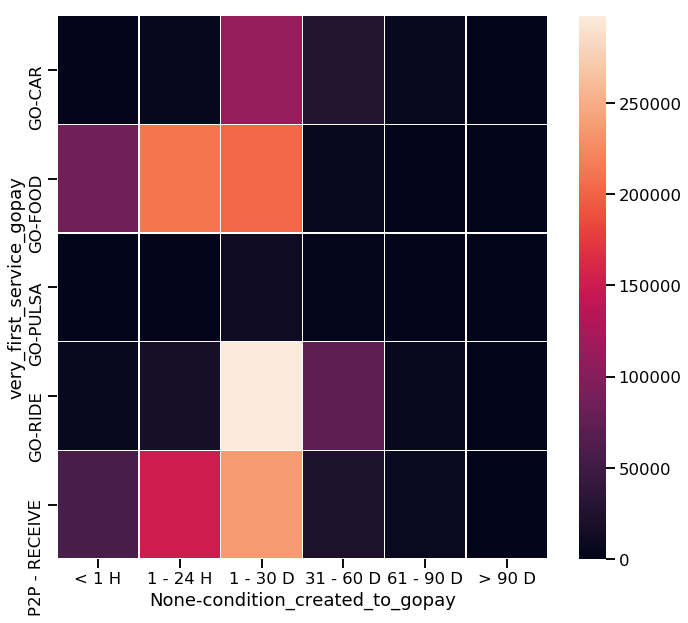

In [22]:
df_1x = df_1.loc[(df_1.very_first_service_gopay.isin(['GO-FOOD', 'P2P - RECEIVE', 'GO-RIDE', 'GO-PULSA','GO-CAR']))]

table_2x = pd.pivot_table(df_1x[['very_first_service_gopay','condition_created_to_gopay', 'customer_id']], 
                            index = ['condition_created_to_gopay','very_first_service_gopay'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)
table_2x = table_2x.unstack(level=0).fillna(0)

short_names = ['< 1 H', '1 - 24 H', '1 - 30 D', '31 - 60 D', '61 - 90 D', '> 90 D']
sns.set_context("talk")
f, ax = plt.subplots(figsize=(11, 10))
# ax = sns.heatmap(table_2a, linewidths=.5)
ax = sns.heatmap(table_2x, linewidths=.5, xticklabels=short_names)
# ax.axes.set_title("Heatmap of Adopters by Day and Hour of Day", fontsize=15, y=1.01)
# ax.set(xlabel='Day of Week', ylabel='Hour');

- Note that for the table and chart above I only highlight the top 5 service types based on the counts.
- Customers mainly first transact on GO-FOOD and P2P - RECEIVE within 24 hours.
- While GO-RIDE, GO-CAR, and GO-PULSA are mainly within 1-30 days.


#### _Part 2: PayLater Activation to PayLater Adoption_

Different from df_1, for PL Activate to PL Adopt, we want to limit the datas into last three months only based on PL activate date (December 2019 to February 2020) just to limit population purpose.

In [125]:
df_2 = original_df[(original_df['paylater_adoption_date'] >= '2019-09-01') & (original_df['paylater_adoption_date'] < '2020-03-01')]

First thing first, I want to know what's the highest count of Gojek service using Gopay after they signed up.

In [170]:
table_1_df_2 = pd.pivot_table(df_2[['service_type_when_adopt_pl','customer_id']], 
                            index = ['service_type_when_adopt_pl'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_1_df_2 = table_1_df_2.sort_values(by=['customer_id'], ascending=False)
table_1_df_2['% of Total'] = (table_1_df_2.customer_id / table_1_df_2.customer_id.sum())
table_1_df_2.to_clipboard()

- Note that for the table and chart below I only highlight the top 5 service types when adopting PL count.
- On the contrary from the previous analysis above, customers adopt the highest in GO-PULSA.

In [172]:
df_2.groupby('service_type_when_adopt_pl')['hour_activate_to_adopt_pl'].describe().sort_values(by=['count'], ascending=False).to_clipboard()

Text(0.5, 1.0, '(PL) Hour Diff. by Service Type')

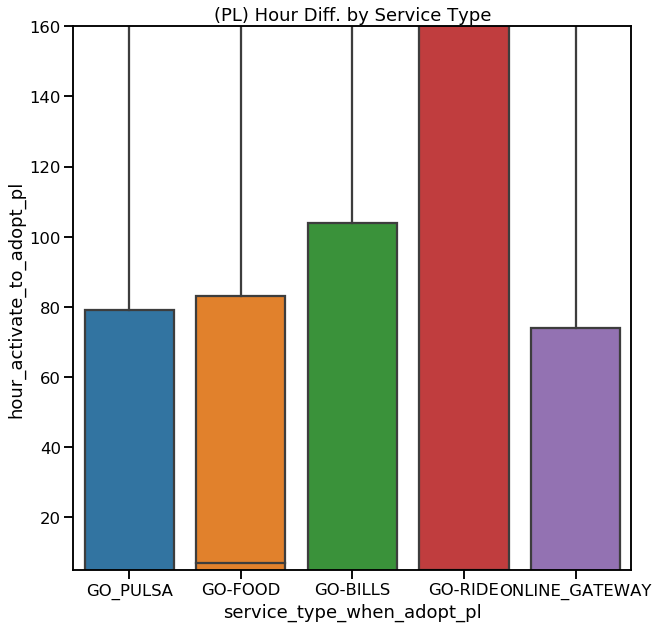

In [173]:
new_df_3 = df_2.loc[(df_2.service_type_when_adopt_pl.isin(['GO_PULSA', 'GO-FOOD','GO-RIDE', 'ONLINE_GATEWAY', 'GO-BILLS']))]

f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='service_type_when_adopt_pl', y='hour_activate_to_adopt_pl', data=new_df_3)
ax.set(ylim=(5, 160))

plt.title("(PL) Hour Diff. by Service Type")

- Note that currently in BQ, there are some dirty datas regarding PayLater activated date. Which is why most of the min results show < 0 (Avtivated Date > Adopt Date).
- Which currently ignore those first and assume those min is 0.
- With that being said, most all trx in the 25% percentile happen within 1 hour.

In [191]:
new_table_2 = df_2.groupby(['condition_activate_to_adopt_pl', 'service_type_when_adopt_pl'])['customer_id'].count().sort_index()
new_table_2a = new_table_2.unstack(level=0).fillna(0)
new_table_2a

condition_activate_to_adopt_pl,1. < 1 H,2. 1 - 24 H,3. 1 - 30 Days,4. 31 - 60 Days,5. 61 - 90 Days,6. > 90 Days
service_type_when_adopt_pl,,,,,,
GO-AUTO,0.0,0.0,1.0,0.0,0.0,0.0
GO-BILLS,2060.0,631.0,1363.0,140.0,95.0,108.0
GO-CLEAN,4.0,0.0,1.0,0.0,0.0,1.0
GO-DAILY,0.0,0.0,0.0,1.0,0.0,0.0
GO-FOOD,6645.0,4120.0,5571.0,600.0,348.0,378.0
GO-MASSAGE,15.0,2.0,11.0,0.0,1.0,2.0
GO-RIDE,5159.0,1697.0,3463.0,670.0,388.0,383.0
GO-SUBSCRIPTIONS,215.0,47.0,165.0,26.0,6.0,15.0
GO-TIX,47.0,21.0,39.0,7.0,2.0,2.0


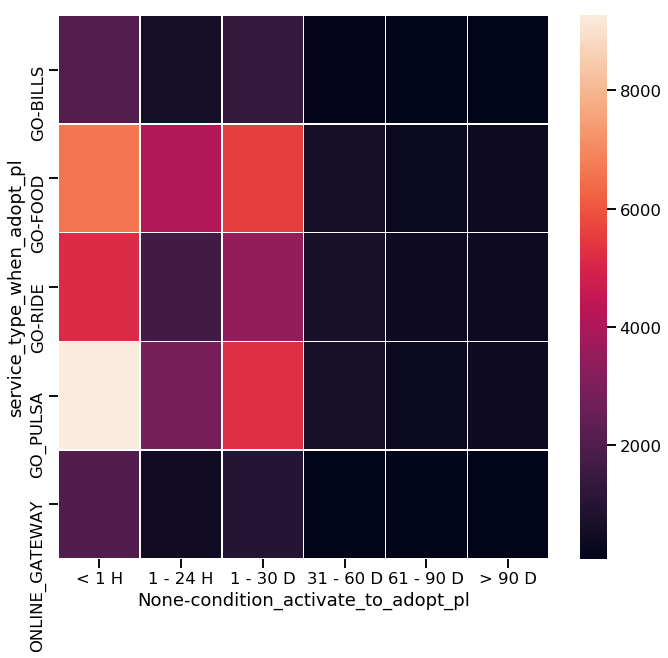

In [130]:
new_df_2 = df_2.loc[(df_2.service_type_when_adopt_pl.isin(['GO_PULSA', 'GO-FOOD','GO-RIDE', 'ONLINE_GATEWAY', 'GO-BILLS']))]

new_table_2x = pd.pivot_table(new_df_2[['service_type_when_adopt_pl','condition_activate_to_adopt_pl', 'customer_id']], 
                            index = ['condition_activate_to_adopt_pl','service_type_when_adopt_pl'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)
new_table_2x = new_table_2x.unstack(level=0).fillna(0)

short_names = ['< 1 H', '1 - 24 H', '1 - 30 D', '31 - 60 D', '61 - 90 D', '> 90 D']
sns.set_context("talk")
f, ax = plt.subplots(figsize=(11, 10))
# ax = sns.heatmap(table_2a, linewidths=.5)
ax = sns.heatmap(new_table_2x, linewidths=.5, xticklabels=short_names)
# ax.axes.set_title("Heatmap of Adopters by Day and Hour of Day", fontsize=15, y=1.01)
# ax.set(xlabel='Day of Week', ylabel='Hour');

- Note that for the table and chart below I only highlight the top 5 service types when adopting PL based on the counts.
- Based on the proportion, most PL adopters happened within 1 hour.

In [195]:
new_df_4 = df_2
new_df_4.groupby(['service_type_when_adopt_pl','kimba_credit_score_bin_when_adopt_paylater'])['minute_activate_to_adopt_pl'].describe().sort_values(by=['count'], ascending=False).to_clipboard()

In [179]:
new_df_4 = df_2
new_df_4.groupby(['kimba_credit_score_bin_when_adopt_paylater'])['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
kimba_credit_score_bin_when_adopt_paylater,,,,,,,,
VLS,30111.0,61.061473,75.847152,0.0,7.00,29.0,87.0,428.0
LS,23470.0,63.457776,75.274571,0.0,6.00,30.0,99.0,418.0
MS,5495.0,62.555414,73.784674,0.0,6.00,31.0,99.5,423.0
VVLS,2675.0,43.829907,59.697084,0.0,7.00,21.0,55.0,399.0
HS,957.0,53.568443,64.776836,0.0,5.00,23.0,85.0,319.0
VHS,54.0,53.351852,68.803016,0.0,5.25,18.5,87.0,307.0


Text(0.5, 1.0, 'Account Created to First Gopay Trx Day Diff. by A-Score Bin')

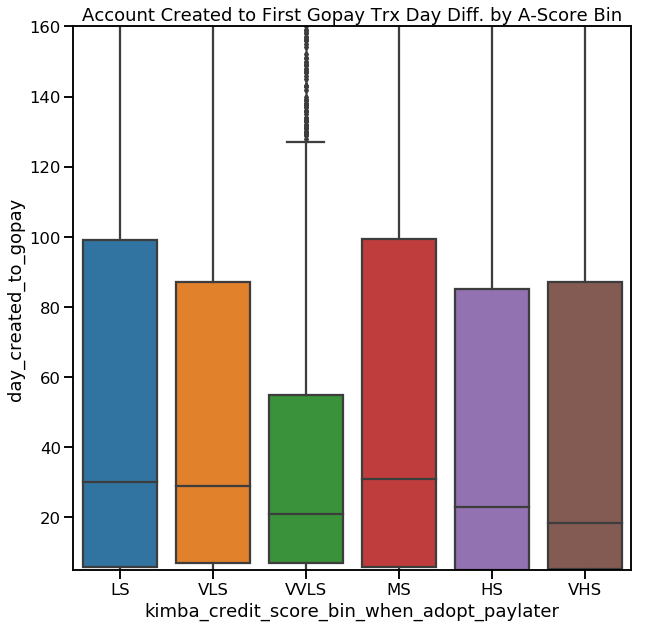

In [180]:
f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='kimba_credit_score_bin_when_adopt_paylater', y='day_created_to_gopay', data=new_df_4)
ax.set(ylim=(5, 160))

plt.title("Account Created to First Gopay Trx Day Diff. by A-Score Bin")

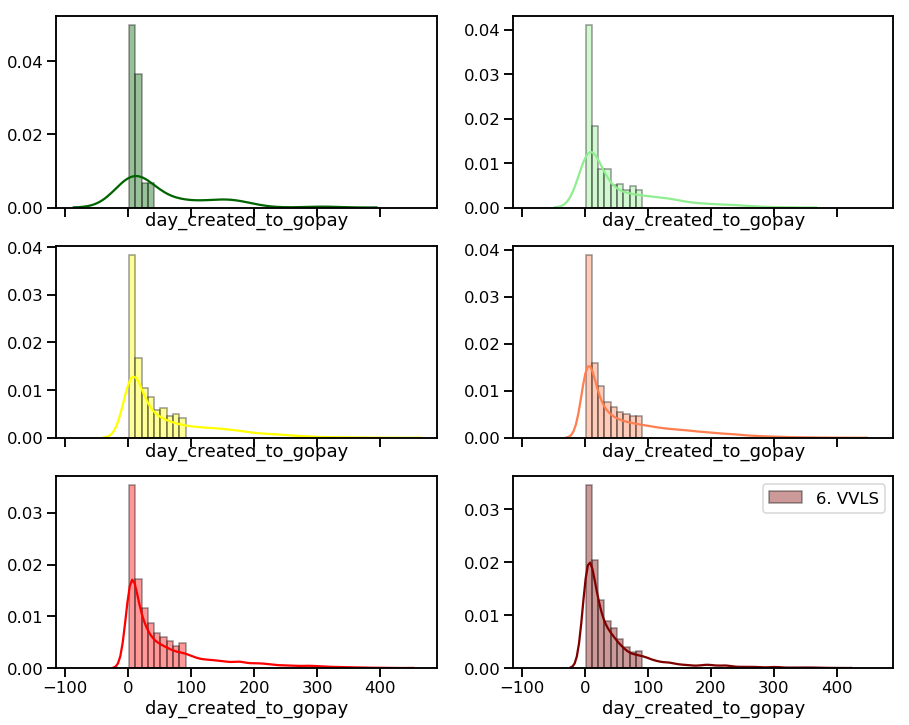

In [134]:
f, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

# f = plt.figure(figsize=(10, 10))

df_VVLS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['VVLS']))]
sns.distplot(df_VVLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'maroon',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 100, 10),
            ax=axes[2, 1],
            label = '6. VVLS'
            )

df_VLS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['VLS']))]
sns.distplot(df_VLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'red',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 100, 10),
            ax=axes[2, 0],
            label = '5. VLS'
            )

df_LS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['LS']))]
sns.distplot(df_LS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'coral',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 100, 10),
            ax=axes[1, 1],
            label = '4. LS'
            )

df_MS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['MS']))]
sns.distplot(df_MS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'yellow',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 100, 10),
            ax=axes[1, 0],
            label = '3. MS'
            )

df_HS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['HS']))]
sns.distplot(df_HS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'lightgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 100, 10),
            ax=axes[0, 1],
            label = '2. HS'
            )

df_VHS = df_2.loc[(df_2.kimba_credit_score_bin_when_adopt_paylater.isin(['VHS']))]
sns.distplot(df_VHS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'darkgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[0, 0],
            label = '1. VHS'
            )

plt.legend()


In [183]:
new_df_6 = df_2.loc[(df_2.dpd > 30)]
new_df_6.groupby(['kimba_credit_score_bin_when_adopt_paylater'])['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False).to_clipboard()

Text(0.5, 1.0, 'Account Created to First Gopay Trx Day Diff. by A-Score Bin (DPD 30+ Customers)')

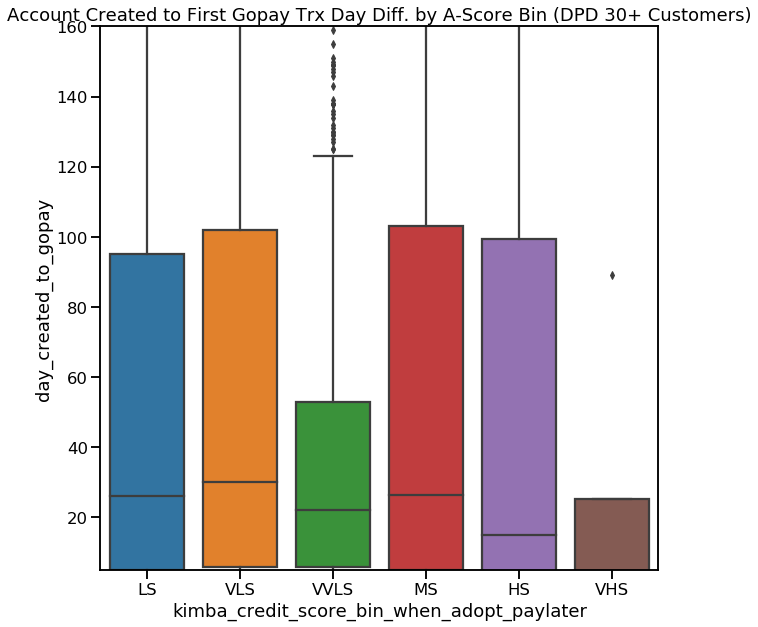

In [182]:
f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='kimba_credit_score_bin_when_adopt_paylater', y='day_created_to_gopay', data=new_df_6)
ax.set(ylim=(5, 160))

plt.title("Account Created to First Gopay Trx Day Diff. by A-Score Bin (DPD 30+ Customers)")

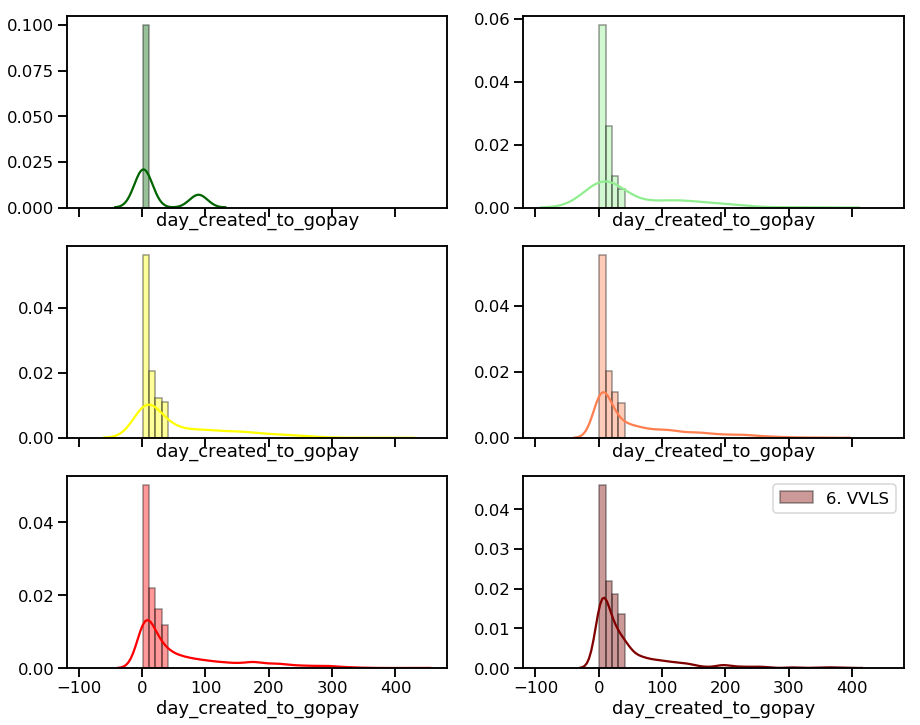

In [137]:
f, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

# f = plt.figure(figsize=(10, 10))

df_VVLS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['VVLS']))]
sns.distplot(df_VVLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'maroon',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[2, 1],
            label = '6. VVLS'
            )

df_VLS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['VLS']))]
sns.distplot(df_VLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'red',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[2, 0],
            label = '5. VLS'
            )

df_LS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['LS']))]
sns.distplot(df_LS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'coral',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[1, 1],
            label = '4. LS'
            )

df_MS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['MS']))]
sns.distplot(df_MS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'yellow',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[1, 0],
            label = '3. MS'
            )

df_HS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['HS']))]
sns.distplot(df_HS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'lightgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[0, 1],
            label = '2. HS'
            )

df_VHS = new_df_6.loc[(new_df_6.kimba_credit_score_bin_when_adopt_paylater.isin(['VHS']))]
sns.distplot(df_VHS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'darkgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[0, 0],
            label = '1. VHS'
            )

plt.legend()


- Based on the table above, 

Text(0.5, 1.0, '(PL) Hour Diff. by Service Type')

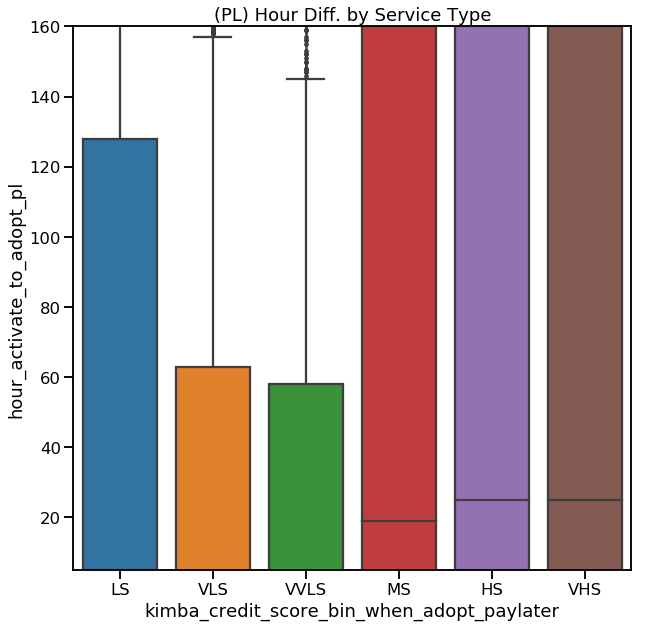

In [138]:
f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='kimba_credit_score_bin_when_adopt_paylater', y='hour_activate_to_adopt_pl', data=new_df_4)
ax.set(ylim=(5, 160))

plt.title("(PL) Hour Diff. by Service Type")

In [139]:
new_df_4.groupby(['kimba_credit_score_bin_when_adopt_paylater'])['service_type_when_adopt_pl'].describe().sort_values(by=['count'], ascending=False)

,count,unique,top,freq
kimba_credit_score_bin_when_adopt_paylater,,,,
VLS,30111,18,GO_PULSA,9564
LS,23470,17,GO-FOOD,6898
MS,5495,18,GO_PULSA,1463
VVLS,2675,16,GO-FOOD,736
HS,957,14,GO-FOOD,247
VHS,54,10,GO-FOOD,18


In [140]:
table_3 = pd.pivot_table(new_df_4[['kimba_credit_score_bin_when_adopt_paylater','service_type_when_adopt_pl', 'customer_id']], 
                            index = ['kimba_credit_score_bin_when_adopt_paylater','service_type_when_adopt_pl'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)
table_3a = table_3.unstack(level=0).fillna(0)
table_3a

customer_id                        \
kimba_credit_score_bin_when_adopt_paylater          HS      LS      MS   VHS   
service_type_when_adopt_pl                                                     
GO-BILLS                                         117.0  1744.0   504.0   3.0   
GO-FOOD                                          247.0  6898.0  1456.0  18.0   
GO-MASSAGE                                         1.0    14.0     2.0   0.0   
GO-RIDE                                          150.0  4424.0   945.0  13.0   
GO-SUBSCRIPTIONS                                   8.0   189.0    65.0   3.0   
GO-TIX                                             2.0    42.0    15.0   0.0   
GOPAY_OFFLINE                                     50.0   622.0   218.0   5.0   
GO_BIRD_COMBO                                     58.0   976.0   222.0   3.0   
GO_FOOD                                            5.0   110.0    26.0   1.0   
GO_KILAT_NEW                                      15.0   263.0    71.0   0.0   
GO_PULSA                                         196.0  6616.0  1463.0   5.0   
ONLINE_GATEWAY                                    99.0  1372.0   457.0   2.0   
PAY_LATER                                          8.0   150.0    28.0   0.0   
SAMEDAY_KILAT                                      1.0    15.0     5.0   0.0   
GO-CLEAN                                           0.0     1.0     2.0   0.0   
GO_BLUE_BIRD                                       0.0     5.0     3.0   1.0   
GO_CAR_XTRA                                        0.0    29.0    12.0   0.0   
GO-AUTO                                            0.0     0.0     1.0   0.0   
GO-DAILY                                           0.0     0.0     0.0   0.0   

                                                           
kimba_credit_score_bin_when_adopt_paylater     VLS   VVLS  
service_type_when_adopt_pl                                 
GO-BILLS                                    1811.0  126.0  
GO-FOOD                                     8000.0  736.0  
GO-MASSAGE                                    14.0    0.0  
GO-RIDE                                     5374.0  613.0  
GO-SUBSCRIPTIONS                             186.0   16.0  
GO-TIX                                        55.0    3.0  
GOPAY_OFFLINE                               1185.0   71.0  
GO_BIRD_COMBO                               1487.0  248.0  
GO_FOOD                                      191.0   15.0  
GO_KILAT_NEW                                 346.0   31.0  
GO_PULSA                                    9564.0  669.0  
ONLINE_GATEWAY                              1727.0  124.0  
PAY_LATER                                     93.0    5.0  
SAMEDAY_KILAT                                 20.0    1.0  
GO-CLEAN                                       1.0    2.0  
GO_BLUE_BIRD                                   4.0    1.0  
GO_CAR_XTRA                                   52.0   14.0  
GO-AUTO                                        0.0    0.0  
GO-DAILY                                       1.0    0.0

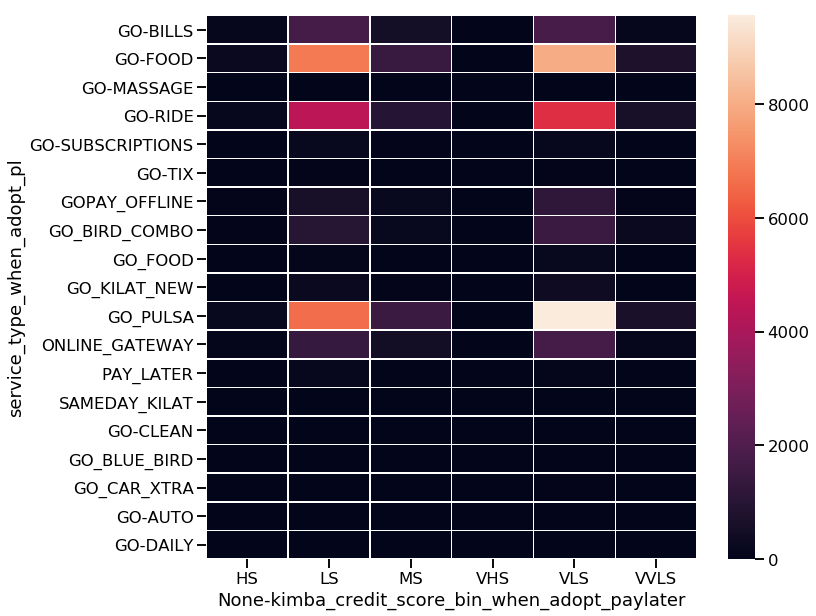

In [141]:
short_names_ = ['HS', 'LS', 'MS', 'VHS', 'VLS', 'VVLS']
sns.set_context("talk")
f, ax = plt.subplots(figsize=(11, 10))
# ax = sns.heatmap(table_2a, linewidths=.5)
ax = sns.heatmap(table_3a, linewidths=.5, xticklabels=short_names_)

In [186]:
new_df_5 = df_2.loc[(df_2.service_type_when_adopt_pl.isin(['GO_PULSA', 'GO-FOOD','GOPAY_OFFLINE', 'ONLINE_GATEWAY', 'GO-BILLS']))]
new_df_5 = new_df_5.loc[(df_2.dpd > 30)]

new_df_5.groupby(['service_type_when_adopt_pl'])['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
service_type_when_adopt_pl,,,,,,,,
GO-FOOD,4367.0,55.339821,70.816283,0.0,4.0,21.0,86.0,354.0
GO_PULSA,4035.0,65.266667,78.996497,0.0,6.0,30.0,99.0,386.0
GOPAY_OFFLINE,1234.0,48.764182,65.988106,0.0,4.0,18.0,59.0,312.0
GO-BILLS,965.0,61.208290,73.810562,0.0,6.0,27.0,92.0,334.0
ONLINE_GATEWAY,693.0,101.489177,99.644739,0.0,14.0,59.0,185.0,417.0


Text(0.5, 1.0, 'Account Created to First Gopay Trx Day Diff. by Service Type (DPD 30+ Customers)')

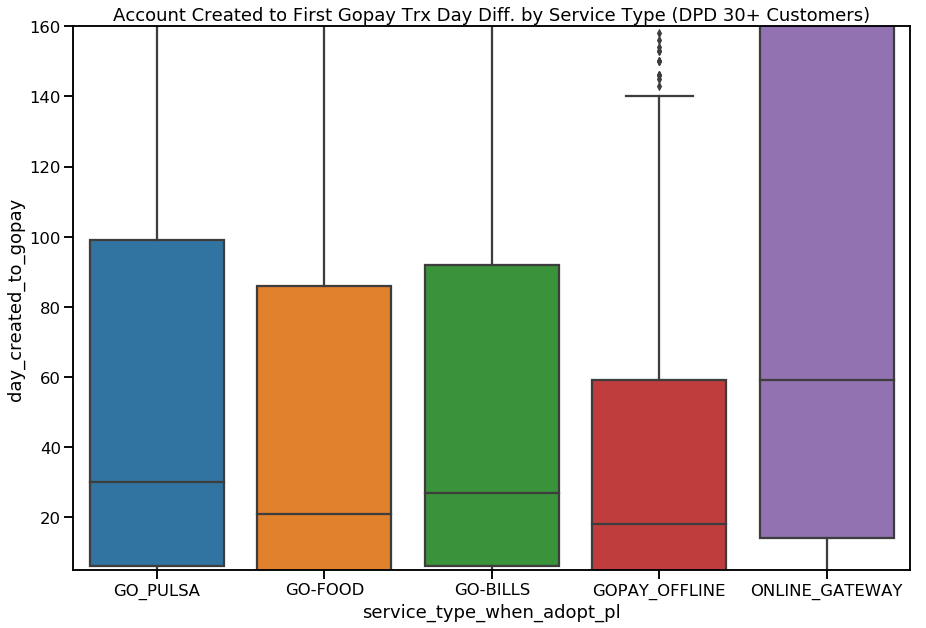

In [187]:
f = plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='service_type_when_adopt_pl', y='day_created_to_gopay', data=new_df_5)
ax.set(ylim=(5, 160))

plt.title("Account Created to First Gopay Trx Day Diff. by Service Type (DPD 30+ Customers)")

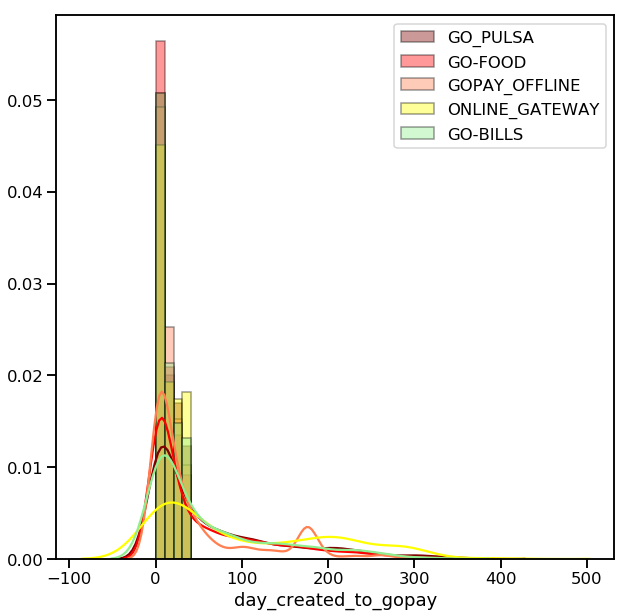

In [189]:
# f, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

f = plt.figure(figsize=(10, 10))

df_VVLS = new_df_5.loc[(new_df_5.service_type_when_adopt_pl.isin(['GO_PULSA']))]
sns.distplot(df_VVLS['day_created_to_gopay'], 
#             hist = True, 
            kde = True,
            color = 'maroon',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
#             ax=axes[2, 0],
            label = 'GO_PULSA'
            )

df_VLS = new_df_5.loc[(new_df_5.service_type_when_adopt_pl.isin(['GO-FOOD']))]
sns.distplot(df_VLS['day_created_to_gopay'], 
#             hist = True, 
            kde = True,
            color = 'red',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
#             ax=axes[1, 1],
            label = 'GO-FOOD'
            )

df_LS = new_df_5.loc[(new_df_5.service_type_when_adopt_pl.isin(['GOPAY_OFFLINE']))]
sns.distplot(df_LS['day_created_to_gopay'], 
#             hist = True, 
            kde = True,
            color = 'coral',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
#             ax=axes[1, 0],
            label = 'GOPAY_OFFLINE'
            )

df_MS = new_df_5.loc[(new_df_5.service_type_when_adopt_pl.isin(['ONLINE_GATEWAY']))]
sns.distplot(df_MS['day_created_to_gopay'], 
#             hist = True, 
            kde = True,
            color = 'yellow',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
#             ax=axes[0, 1],
            label = 'ONLINE_GATEWAY'
            )

df_HS = new_df_5.loc[(new_df_5.service_type_when_adopt_pl.isin(['GO-BILLS']))]
sns.distplot(df_HS['day_created_to_gopay'], 
#             hist = True, 
            kde = True,
            color = 'lightgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
#             ax=axes[0, 0],
            label = 'GO-BILLS'
            )

plt.legend()


In [161]:
df_p2p = df_2.loc[(df_2.very_first_service_gopay.isin(['P2P - RECEIVE']))]

In [168]:
df_p2p.groupby(['kimba_credit_score_bin_when_adopt_paylater'])['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
kimba_credit_score_bin_when_adopt_paylater,,,,,,,,
VLS,955.0,70.719372,90.553705,0.0,3.00,22.0,149.00,428.0
LS,177.0,64.265537,88.405462,0.0,2.00,17.0,97.00,360.0
VVLS,55.0,47.109091,76.443800,0.0,3.50,16.0,55.50,337.0
MS,28.0,68.250000,104.279050,0.0,4.75,26.0,56.75,399.0


Text(0.5, 1.0, '(P2P - RECEIVE) Account Created to First Gopay Trx Day Diff. by A-Score')

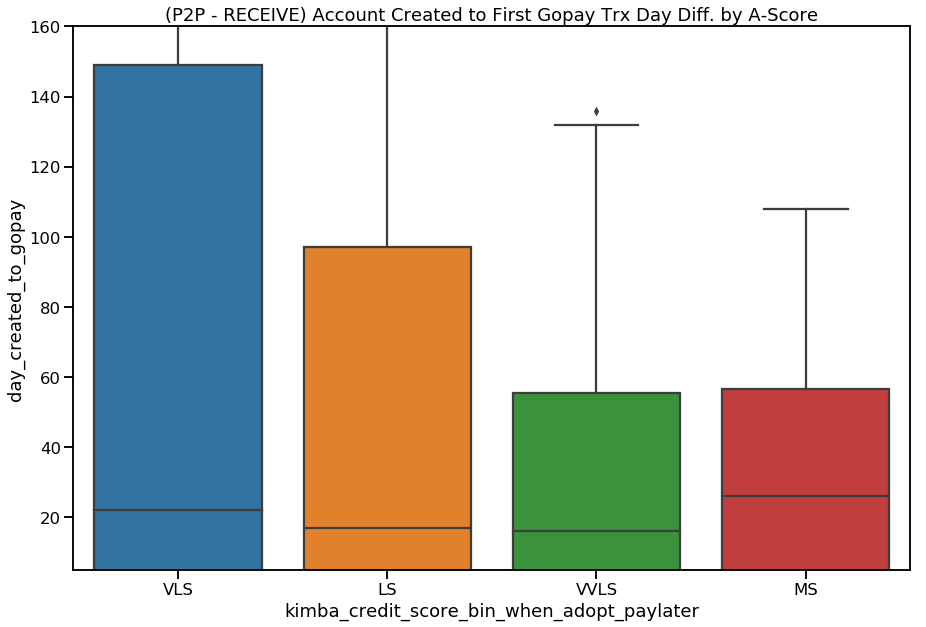

In [166]:
f = plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='kimba_credit_score_bin_when_adopt_paylater', y='day_created_to_gopay', data=df_p2p)
ax.set(ylim=(5, 160))

plt.title("(P2P - RECEIVE) Account Created to First Gopay Trx Day Diff. by A-Score")

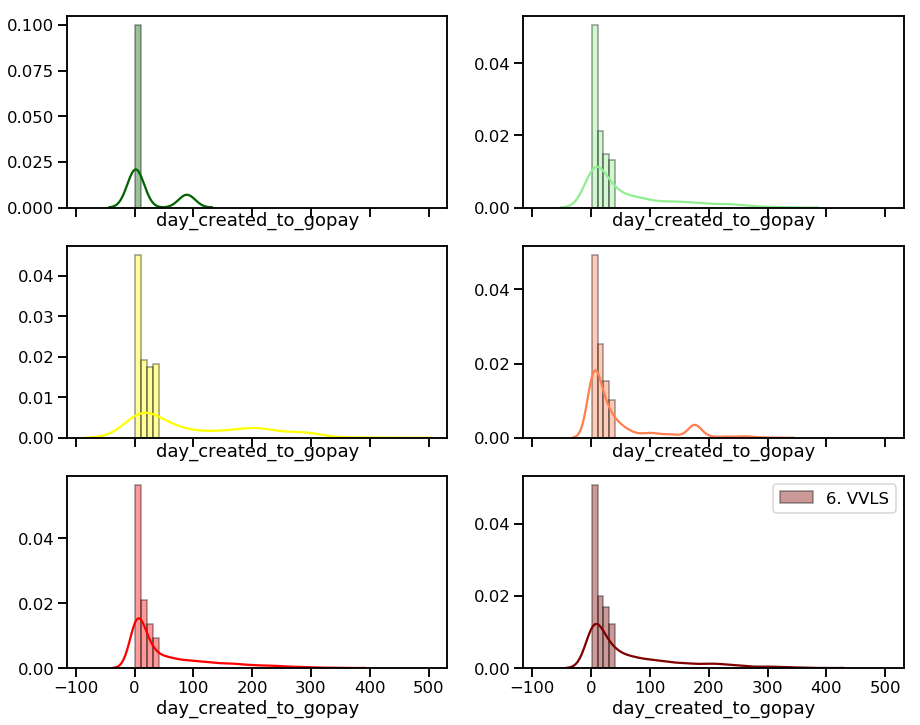

In [165]:
f, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

# f = plt.figure(figsize=(10, 10))

df_VVLS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['VVLS']))]
sns.distplot(df_VVLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'maroon',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[2, 1],
            label = '6. VVLS'
            )

df_VLS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['VLS']))]
sns.distplot(df_VLS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'red',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[2, 0],
            label = '5. VLS'
            )

df_LS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['LS']))]
sns.distplot(df_LS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'coral',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[1, 1],
            label = '4. LS'
            )

df_MS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['MS']))]
sns.distplot(df_MS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'yellow',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[1, 0],
            label = '3. MS'
            )

df_HS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['HS']))]
sns.distplot(df_HS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'lightgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[0, 1],
            label = '2. HS'
            )

df_VHS_ = df_p2p.loc[(df_p2p.kimba_credit_score_bin_when_adopt_paylater.isin(['VHS']))]
sns.distplot(df_VHS['day_created_to_gopay'], 
            hist = True, 
            kde = True,
            color = 'darkgreen',
            hist_kws={'edgecolor':'black'},
            bins=range(1, 50, 10),
            ax=axes[0, 0],
            label = '1. VHS'
            )

plt.legend()


In [148]:
df_p2p.groupby(['service_type_when_adopt_pl'])['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
service_type_when_adopt_pl,,,,,,,,
ONLINE_GATEWAY,403.0,50.684864,74.058417,0.0,1.00,16.0,68.00,371.0
GO-FOOD,343.0,63.294461,98.204752,0.0,3.00,16.0,74.50,428.0
GOPAY_OFFLINE,236.0,97.046610,86.511652,0.0,8.75,106.0,176.00,260.0
GO-RIDE,122.0,87.516393,99.290894,0.0,15.00,47.0,126.50,411.0
GO_BIRD_COMBO,84.0,60.059524,87.081924,0.0,4.00,35.0,44.50,357.0
GO_KILAT_NEW,17.0,111.352941,106.316709,0.0,5.00,117.0,134.00,310.0
GO-SUBSCRIPTIONS,8.0,68.000000,66.110297,4.0,8.75,49.0,129.00,169.0
GO_FOOD,4.0,161.750000,142.717378,0.0,75.75,158.5,244.50,330.0
GO_CAR_XTRA,3.0,11.333333,18.770544,0.0,0.50,1.0,17.00,33.0


Text(0.5, 1.0, 'Account Created to First Gopay Trx Day Diff. by Service Type (DPD 30+ Customers)')

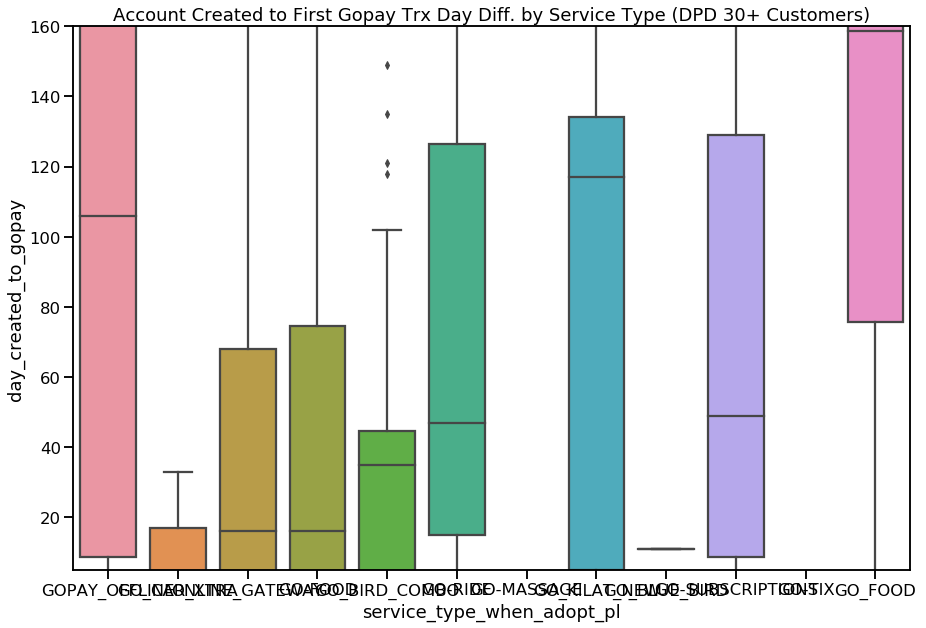

In [149]:
f = plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='service_type_when_adopt_pl', y='day_created_to_gopay', data=df_p2p)
ax.set(ylim=(5, 160))

plt.title("Account Created to First Gopay Trx Day Diff. by Service Type (DPD 30+ Customers)")

In [150]:
table_df_p2p = pd.pivot_table(df_p2p[['service_type_when_adopt_pl','customer_id']], 
                            index = ['service_type_when_adopt_pl'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_df_p2p = table_df_p2p.sort_values(by=['customer_id'], ascending=False)
table_df_p2p['% of Total'] = (table_df_p2p.customer_id / table_df_p2p.customer_id.sum())
table_df_p2p

,customer_id,% of Total
service_type_when_adopt_pl,,
ONLINE_GATEWAY,403,0.329248
GO-FOOD,343,0.280229
GOPAY_OFFLINE,236,0.192810
GO-RIDE,122,0.099673
GO_BIRD_COMBO,84,0.068627
GO_KILAT_NEW,17,0.013889
GO-SUBSCRIPTIONS,8,0.006536
GO_FOOD,4,0.003268
GO_CAR_XTRA,3,0.002451


In [159]:
table_df_p2p_1 = pd.pivot_table(df_p2p[['kimba_credit_score_bin_when_adopt_paylater','customer_id']], 
                            index = ['kimba_credit_score_bin_when_adopt_paylater'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_df_p2p_1 = table_df_p2p_1.sort_values(by=['customer_id'], ascending=False)
table_df_p2p_1['% of Total'] = (table_df_p2p_1.customer_id / table_df_p2p_1.customer_id.sum())
table_df_p2p_1

,customer_id,% of Total
kimba_credit_score_bin_when_adopt_paylater,,
VLS,955,0.786008
LS,177,0.145679
VVLS,55,0.045267
MS,28,0.023045


In [160]:
table_df_p2p_2 = pd.pivot_table(df_p2p[['kimba_credit_score_bin_when_adopt_paylater','service_type_when_adopt_pl', 'customer_id']], 
                            index = ['kimba_credit_score_bin_when_adopt_paylater','service_type_when_adopt_pl'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_df_p2p_2 = table_df_p2p_2.sort_values(by=['customer_id'], ascending=False).unstack(level=0).fillna(0)
# table_df_p2p_2['% of Total'] = (table_df_p2p_2.customer_id / table_df_p2p_2.customer_id.sum())
table_df_p2p_2

customer_id                   
kimba_credit_score_bin_when_adopt_paylater          LS    MS    VLS  VVLS
service_type_when_adopt_pl                                               
GO-FOOD                                           71.0   8.0  238.0  25.0
GO-MASSAGE                                         0.0   0.0    1.0   0.0
GO-RIDE                                           14.0   2.0   93.0  13.0
GO-SUBSCRIPTIONS                                   2.0   1.0    5.0   0.0
GO-TIX                                             0.0   0.0    2.0   0.0
GOPAY_OFFLINE                                     13.0   0.0  216.0   1.0
GO_BIRD_COMBO                                     14.0   0.0   65.0   4.0
GO_BLUE_BIRD                                       0.0   0.0    0.0   1.0
GO_CAR_XTRA                                        0.0   0.0    2.0   1.0
GO_FOOD                                            0.0   0.0    3.0   1.0
GO_KILAT_NEW                                       2.0   1.0   12.0   2.0
ONLINE_GATEWAY                                    61.0  16.0  318.0   7.0

#### _Part 4: Blacklisted Customers Behavior

In [198]:
df_3 = original_df.loc[(original_df.is_blacklisted.isin(['1']))]

In [199]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 11713 to 10986338
Data columns (total 26 columns):
customer_id                                          435 non-null int64
date_customer_created_at                             435 non-null datetime64[ns]
datetime_customer_created_at                         435 non-null datetime64[ns]
date_first_booking_complete_date_gopay_or_p2p        435 non-null datetime64[ns]
datetime_first_booking_complete_date_gopay_or_p2p    435 non-null datetime64[ns]
paylater_adoption_date                               435 non-null datetime64[ns]
very_first_service_gopay                             435 non-null object
due_date                                             435 non-null datetime64[ns]
pl_spend                                             428 non-null float64
outstanding_principal                                435 non-null float64
dpd                                                  428 non-null float64
paylater_activate_date           

In [200]:
table_b = pd.pivot_table(df_3[['very_first_service_gopay','customer_id']], 
                            index = ['very_first_service_gopay'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_b = table_b.sort_values(by=['customer_id'], ascending=False)
table_b['% of Total'] = (table_b.customer_id / table_b.customer_id.sum())
table_b

,customer_id,% of Total
very_first_service_gopay,,
GO-FOOD,199,0.457471
GO-PULSA,72,0.165517
GO-RIDE,67,0.154023
GO-CAR,37,0.085057
GO-BILLS,36,0.082759
GO-SHOP,5,0.011494
P2P - SEND,5,0.011494
GO-DEALS,4,0.009195
P2P - RECEIVE,4,0.009195


In [214]:
df_3.groupby('is_blacklisted')['day_created_to_gopay'].describe().sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
is_blacklisted,,,,,,,,
1,435.0,29.34023,34.604602,0.0,3.0,15.0,44.0,240.0


Text(0.5, 1.0, 'Account Created to First Gopay Trx Day Diff. for Blacklisted Customers')

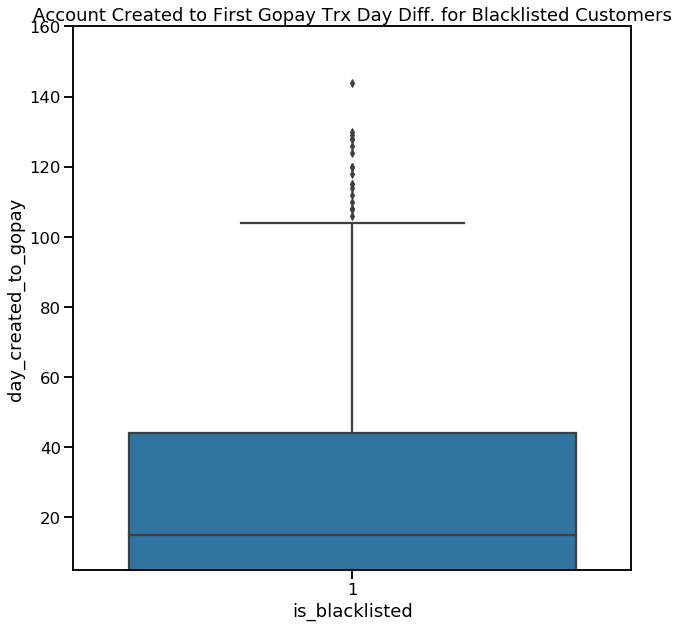

In [215]:
f = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='is_blacklisted', y='day_created_to_gopay', data=df_3)
ax.set(ylim=(5, 160))

plt.title("Account Created to First Gopay Trx Day Diff. for Blacklisted Customers")

In [216]:
table_b_2 = pd.pivot_table(df_3[['condition_created_to_gopay','customer_id']], 
                            index = ['condition_created_to_gopay'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_b_2 = table_b_2.sort_values(by=['condition_created_to_gopay'], ascending=True)
table_b_2['% of Total'] = (table_b_2.customer_id / table_b_2.customer_id.sum())
table_b_2

,customer_id,% of Total
condition_created_to_gopay,,
1. < 1 H,12,0.027586
2. 1 - 24 H,53,0.121839
3. 1 - 30 Days,221,0.508046
4. 31 - 60 Days,73,0.167816
5. 61 - 90 Days,40,0.091954
6. > 90 Days,36,0.082759


In [220]:
table_b_3 = pd.pivot_table(df_3[['kimba_credit_score_bin_when_adopt_paylater','customer_id']], 
                            index = ['kimba_credit_score_bin_when_adopt_paylater'], 
                            aggfunc = 'count', 
                            fill_value = 0
                           ).fillna(0)

table_b_3 = table_b_3.sort_values(by=['customer_id'], ascending=False)
table_b_3['% of Total'] = (table_b_3.customer_id / table_b_3.customer_id.sum())
table_b_3.to_clipboard()